In [1]:
import random

import torch
from torch import nn

# Redes Neuronales Recurrentes: Cálculo de Gradientes

En el presente cuaderno de Jupyter, exploraremos la naturaleza y funcionalidad de las celdas recurrentes en las redes neuronales. De manera específica, analizaremos una configuración de dos celdas recurrentes básicas conectadas en serie y realizaremos el cálculo de sus gradientes de forma manual asumiendo una función de pérdida de entropía cruzada para un problema de clasificación. Posteriormente, contrastaremos nuestros cálculos manuales con una implementación de la red en PyTorch. En la siguiente imagen se muestra el diagrama de la red por analizar.

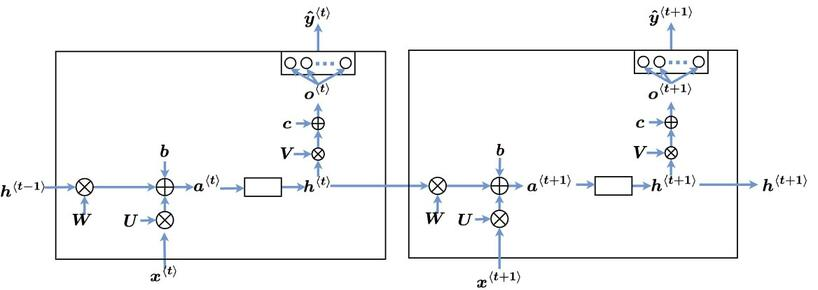

In [2]:
torch.manual_seed(0);

In [3]:
def random_one_hot_tensor(n: int) -> torch.FloatTensor:
    """Genera un tensor one-hot aleatorio de tamaño n. Un tensor one-hot es un tensor que contiene
        principalmente ceros y tiene un único elemento con valor uno.

    :param n: El tamaño del tensor one-hot a generar.
    :return: Un tensor one-hot de tamaño n con un valor en un índice aleatorio igual a 1 
             y el resto de los valores en 0.
    """
    non_zero_index = random.randint(0, n - 1)
    one_hot_tensor = torch.zeros(n, 1, dtype=torch.float32)
    one_hot_tensor[non_zero_index] = 1
    return one_hot_tensor

In [4]:
nh = 2  # Tamaño del estado oculto.
nx = 2  # Tamaño del tensor de entrada.
ny = 4  # Tamaño del tensor de salida

# Inicialización de parámetro de la red de forma aleatoria.
b = torch.rand(nh, 1, requires_grad=True)
c = torch.rand(ny, 1, requires_grad=True)
U = torch.rand(nh, nx, requires_grad=True)
W = torch.rand(nh, nh, requires_grad=True)
V = torch.rand(ny, nh, requires_grad=True)

# Aunque en un contexto práctico no tiene sentido llevar el registro del gradiente con respecto a h0,
# optaremos por realizarlo aquí con fines puramente educativos.
h0 = torch.rand(nh, 1, requires_grad=True)

# Definimos de forma aleatoria tanto la entrada como el objetivo (target) de cada celda.
x1 = torch.rand(nx, 1)
t1 = random_one_hot_tensor(n=ny)
x2 = torch.rand(nx, 1)
t2 = random_one_hot_tensor(n=ny)

In [5]:
print(f"t1: {t1}")
print(f"t2: {t2}")

t1: tensor([[0.],
        [0.],
        [1.],
        [0.]])
t2: tensor([[1.],
        [0.],
        [0.],
        [0.]])


In [6]:
# Propagación hacia adelante de la red.
a1 = torch.matmul(W, h0) + torch.matmul(U, x1) + b
h1 = nn.Tanh()(a1)
o1 = torch.matmul(V, h1) + c
y1 = nn.functional.softmax(o1, dim=0)
# la función cross_entropy espera una entrada de dimensiones (N, C) en donde N es el tamaño de bache y C es el número de clases. En este caso,
# transformamos o1 para cambiar su tamaño de (4, 1) a (1, 4). La función también espera como target un tensor de tamaño (N) que contiene
# los índices de las clases objetivo.
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
# https://pytorch.org/docs/stable/generated/torch.argmax.html
l1 = torch.nn.functional.cross_entropy(input=torch.reshape(o1, (1, ny)), target=torch.argmax(t1, dim=0))

a2 = torch.matmul(W, h1) + torch.matmul(U, x2) + b
h2 = nn.Tanh()(a2)
o2 = torch.matmul(V, h2) + c
y2 = nn.functional.softmax(o2, dim=0)
l2 = torch.nn.functional.cross_entropy(input=torch.reshape(o2, (1, ny)), target=torch.argmax(t2, dim=0))

loss = l1 + l2

In [7]:
print(f"a1.shape: {a1.shape}")
print(f"h1.shape: {h1.shape}")
print(f"o1.shape: {o1.shape}")
print(f"y1.shape: {y1.shape}")
print(f"a2.shape: {a2.shape}")
print(f"h2.shape: {h2.shape}")
print(f"o2.shape: {o2.shape}")
print(f"y2.shape: {y2.shape}")
print(f"loss: {loss}")

a1.shape: torch.Size([2, 1])
h1.shape: torch.Size([2, 1])
o1.shape: torch.Size([4, 1])
y1.shape: torch.Size([4, 1])
a2.shape: torch.Size([2, 1])
h2.shape: torch.Size([2, 1])
o2.shape: torch.Size([4, 1])
y2.shape: torch.Size([4, 1])
loss: 4.114384651184082


In [8]:
# Por defecto, PyTorch solo guarda los gradientes para los tensores hoja (leafe tensor) y elimina los otros para ahorrar memoria.
# Un tensor hoja en PyTorch es un tensor que no es el resultado de una operación, es decir, un tensor que fue inicializado directamente
# por el usuario. Por eso aquí, de manera explícita, le pedimos a PyTorch que guarde los gradientes de h1 y h2.
h1.retain_grad()
h2.retain_grad()

In [9]:
# Propagación hacia atras de la red.
loss.backward()

## Gradiente con respecto a c

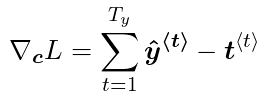

In [10]:
c.grad

tensor([[-0.7289],
        [ 0.5306],
        [-0.7585],
        [ 0.9569]])

In [11]:
(y1 - t1) + (y2 - t2)

tensor([[-0.7289],
        [ 0.5306],
        [-0.7585],
        [ 0.9569]], grad_fn=<AddBackward0>)

## Gradiente con respecto a b

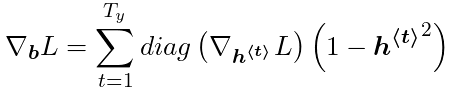

In [12]:
b.grad

tensor([[0.0899],
        [0.1464]])

In [13]:
(
    torch.diag(h1.grad.squeeze()) @ (1 - h1 ** 2) +
    torch.diag(h2.grad.squeeze()) @ (1 - h2 ** 2)
)

tensor([[0.0899],
        [0.1464]], grad_fn=<AddBackward0>)

## Gradiente con respecto a h0, h1 y h2

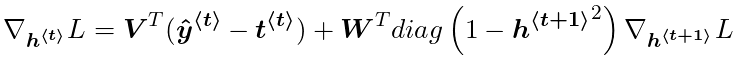

In [14]:
h0.grad

tensor([[0.0210],
        [0.0379]])

In [15]:
(W.T @ torch.diag((1 - h1 ** 2).squeeze())) @ h1.grad

tensor([[0.0210],
        [0.0379]], grad_fn=<MmBackward0>)

In [16]:
h1.grad

tensor([[0.4233],
        [0.4955]])

In [17]:
(W.T @ torch.diag((1 - h2 ** 2).squeeze())) @ h2.grad + (V.T @ (y1 - t1))

tensor([[0.4233],
        [0.4955]], grad_fn=<AddBackward0>)

In [18]:
h2.grad

tensor([[0.2763],
        [0.2356]])

In [19]:
(V.T @ (y2 - t2))

tensor([[0.2763],
        [0.2356]], grad_fn=<MmBackward0>)

## Gradiente con respecto a **W**

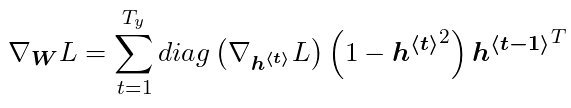

In [20]:
W.grad

tensor([[0.0549, 0.0795],
        [0.0856, 0.1293]])

In [21]:
(
    torch.diag(h1.grad.squeeze()) @ (1 - h1 ** 2) @ h0.T +
    torch.diag(h2.grad.squeeze()) @ (1 - h2 ** 2) @ h1.T
)

tensor([[0.0549, 0.0795],
        [0.0856, 0.1293]], grad_fn=<AddBackward0>)

## Gradiente con respecto a **U**

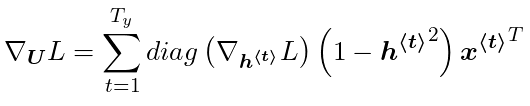

In [22]:
U.grad

tensor([[0.0567, 0.0313],
        [0.0887, 0.0545]])

In [23]:
(
    torch.diag(h1.grad.squeeze()) @ (1 - h1 ** 2) @ x1.T +
    torch.diag(h2.grad.squeeze()) @ (1 - h2 ** 2) @ x2.T
)

tensor([[0.0567, 0.0313],
        [0.0887, 0.0545]], grad_fn=<AddBackward0>)

## Gradiente con respecto a **V**

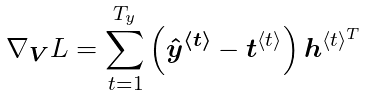

In [24]:
V.grad

tensor([[-0.6801, -0.6431],
        [ 0.4953,  0.4731],
        [-0.7084, -0.6834],
        [ 0.8933,  0.8534]])

In [25]:
(y1 - t1) @ h1.T + (y2 - t2) @ h2.T

tensor([[-0.6801, -0.6431],
        [ 0.4953,  0.4731],
        [-0.7084, -0.6834],
        [ 0.8933,  0.8534]], grad_fn=<AddBackward0>)